# Lost load event selection

To run this file you will need to download the pickle files from Zenodo: https://zenodo.org/records/10403697

Figure S12

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from glob import glob
import pickle
from collections import OrderedDict
from IPython.display import display
from datetime import datetime, timedelta

import matplotlib as mpl
mpl.rcParams["savefig.dpi"] = 300
#mpl.rcParams["font.size"] = 15
mpl.rcParams["lines.linewidth"] = 2
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [2]:
pdf = True
svg = True
original = False


#n_years_Aug04v1_SWB_CONUS_TestArchs
#(lifte4) [MEM]$ cd plotting-scripts/final_scripts/

# FINAL DATE
DATE = 'Aug04v1'

norm = {
    'CONUS' : 303461, # Mean demand (MW) for file CONUS_demand_synthetic_1950-2020_MEM.csv
}

year_range = range(1979, 2021)

In [3]:
delta_t = 4 # hours per timestep
steps_per_day = int(24 / delta_t)

def add_rolling(df):
    
    L = len(df.index)
    for col in ['demand potential', 'solar potential', 'wind potential']:
        df[f'{col} roll'] = df[col].rolling(steps_per_day).mean()
        # apply wrapping
        for idx in range(steps_per_day - 1):
            val = df.loc[0:idx][col].sum()
            L1 = len(df.loc[0:idx])
            #print(L-1-(steps_per_day-idx), L-1, L1, 
            #      len(df.loc[L-steps_per_day+L1:L-1]))
            val += df.loc[L-steps_per_day+L1:L-1, col].sum()
            val /= steps_per_day
            df.loc[idx, f'{col} roll'] = val
    return df

def build_df(DATE, techs):
    
    files = glob(f'../../Output_Data/n_years_{DATE}_{techs}_CONUS_TestArchs/CONUS_nYears-1/nYrs_*/*.pickle')
    
    D = {
        'opt_year': [],
        'test_year': [],
        'max_ll': [],
        'max_idx': [],
        'demand': [],
        'solar': [],
        'wind': [],
    }
    
    skipped = 0
    for f in files:
        ### Try to open file before appending anything
        ### b/c we might need to skip this file
        try:
            infile = open(f,'rb')
            pi = pickle.load(infile)
            infile.close()
        except:
            print(f"Loading file {f} did not work, skipping this file.")
            continue
        
        df = pd.DataFrame(pi[1][2])
        df = add_rolling(df)
        info = f.split('/')[-1]
        opt_year = int(info.split('DYrs')[-1].split('_')[0])
        test_year = int(info.split('Tested')[-1].split('_')[0])
        opt_year = opt_year + 2000 if opt_year < 50 else opt_year + 1900
        #print(info, opt_year, test_year)
        MAX = np.max(df['lost_load dispatch'])
        if MAX == 0.0:
            skipped += 1
            #print(f"skipped {skipped}; Skipping test year: {test_year} and opt year {opt_year} with zero LL")
            continue
        idxmax = np.where(df['lost_load dispatch'] == MAX)
        if len(idxmax) == 0:
            continue
        if len(idxmax) > 1 and MAX != 0.0:
            continue
        #print(idxmax, MAX)
        #print(df.loc[idxmax])
        D['opt_year'].append(opt_year)
        D['test_year'].append(test_year)
        D['max_ll'].append(MAX)
        D['max_idx'].append(idxmax[0][0])
        D['demand'].append(df.loc[idxmax, 'demand potential roll'].sum())
        D['solar'].append(df.loc[idxmax, 'solar potential roll'].sum() / pi[1][1]['solar capacity'])
        D['wind'].append(df.loc[idxmax, 'wind potential roll'].sum() / pi[1][1]['wind capacity'])
        #return df
    df = pd.DataFrame(D)
    df = df.sort_values(by=['opt_year', 'test_year'])
    print(f"skipped {skipped} tests with zero LL")
    return df

def get_avgs(df):
    # Get AVGS for 3 profiles for 1979-2020
    base = '../../Input_Data/n_years2/'

    s = '20210921_US_mthd3_1950-2020_solar_deltaT4.csv'
    w = '20210921_US_mthd3_1950-2020_wind_deltaT4.csv'
    d = 'CONUS_demand_synthetic_1950-2020_MEM_deltaT4.csv'
    dem = pd.read_csv(f'{base}{d}', header=1)
    dem = dem[ dem['year'] >= 1979 ]
    wind = pd.read_csv(f'{base}{w}', header=1)
    wind = wind[ wind['year'] >= 1979 ]
    solar = pd.read_csv(f'{base}{s}', header=1)
    solar = solar[ solar['year'] >= 1979 ]
    avg_dem = np.mean(dem['demand (MW)'])
    avg_wind = np.mean(wind['w_cfs'])
    avg_solar = np.mean(solar['s_cfs'])
    print('avg dem', avg_dem)
    print('avg wind', avg_wind)
    print('avg solar', avg_solar)

    # Normalize values as % of AVGs
    df['demand_n'] = df['demand'] / avg_dem
    df['wind_n'] = df['wind'] / avg_wind
    df['solar_n'] = df['solar'] / avg_solar
    return df

# Add month groups
# Forget about leap days
def get_months(df):
    df['month'] = 0
    dt = datetime(year=2021, month=1, day=1, hour=0)
    #print(dt)
    month_start_idx = 0
    prev_month = 1
    time_idx = 0
    while dt.year == 2021:
        dt += timedelta(hours=4)
        time_idx += 1
        if prev_month != dt.month:
            df['month'] = np.where(
                (df['max_idx'] >= month_start_idx) & 
                (df['max_idx'] < time_idx), prev_month, df['month'])
            prev_month = dt.month
            month_start_idx = time_idx
    
    mos = df['month'].unique()
    mos.sort()
    print(mos)
    return df

def get_seasons(df):
    df['seasons'] = ''
    df['seasons'] = np.where((df['month'] <= 3) |
                             (df['month'] >= 11), 
                             'heating', 'cooling')
    print(df['seasons'].unique())
    return df

dfs = OrderedDict()
for techs in ['SWB', 'SWBNG', 'SWBPGP']:
    print(techs)
    if original:
        df = build_df(DATE, techs)
        df.to_csv(f'si_fig_Lost_Load_Event_Selection_{techs}.csv')
    else:
        df = pd.read_csv(f'si_fig_Lost_Load_Event_Selection_{techs}.csv')
    df = get_avgs(df)
    df = get_months(df)
    df = get_seasons(df)
    dfs[techs] = df

SWB
avg dem 303894.4947960802
avg wind 0.28544165098982893
avg solar 0.26458857617332354
[ 1  2  3  6  7  8  9 11 12]
['heating' 'cooling']
SWBNG
avg dem 303894.4947960802
avg wind 0.28544165098982893
avg solar 0.26458857617332354
[ 1  2  3  7  8 12]
['heating' 'cooling']
SWBPGP
avg dem 303894.4947960802
avg wind 0.28544165098982893
avg solar 0.26458857617332354
[ 1  2  3  7  8  9 10 12]
['heating' 'cooling']


SWB, total 1221, heating 917, cooling 304
SWB, mean wind 0.09083381307496445
SWBNG, total 930, heating 707, cooling 223
SWBNG, mean wind 0.11564409934335092
SWBPGP, total 1409, heating 416, cooling 993
SWBPGP, mean wind 0.10752945560445144
Saving: plots/si_fig_event_type.png


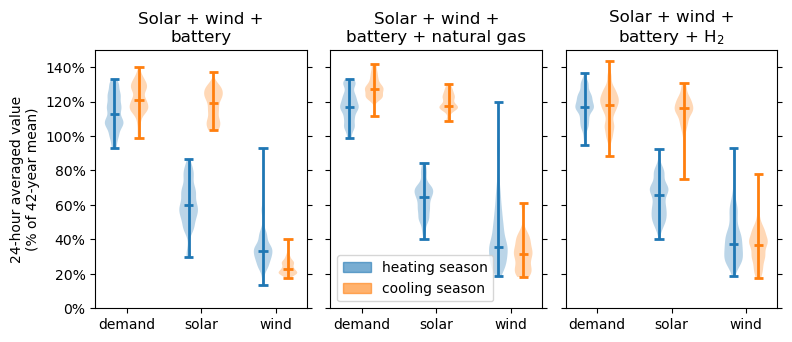

In [4]:
title_map = {
    'SWB' : 'Solar + wind + battery',
    'SWBNG' : 'Solar + wind + battery + natural gas',
    'SWBPGP' : r'Solar + wind + battery + H$_{2}$'
}
title_map = {
    'SWB' : 'Solar + wind +\nbattery',
    'SWBNG' : 'Solar + wind +\nbattery + natural gas',
    'SWBPGP' : 'Solar + wind +\n'+r'battery + H$_{2}$'
}

# Plot box whisker of events
def plot_violins(dfs):
    fig, axs = plt.subplots(sharey=True, figsize=(8, 3.5), ncols=3)
    x1s = [1, 4, 7]
    x2s = [2, 5, 8]
    for i, (techs, df) in enumerate(dfs.items()):
        df1 = df[ df['seasons'] == 'heating' ]
        parts = axs[i].violinplot([df1['demand_n'], df1['solar_n'], df1['wind_n']],
                        positions=x1s,
                        showmeans=False,
                        showmedians=True,
                        showextrema=True,
                        widths=0.75)
        
        df2 = df[ df['seasons'] == 'cooling' ]
        parts = axs[i].violinplot([df2['demand_n'], df2['solar_n'], df2['wind_n']],
                        positions=x2s,
                        showmeans=False,
                        showmedians=True,
                        showextrema=True,
                        widths=0.75)
        
        print(f'{techs}, total {len(df.index)}, heating {len(df1.index)}, cooling {len(df2.index)}')
        print(f'{techs}, mean wind {np.mean(df["wind_n"]) * 0.28544165098982893}') # 0.28544165098982893 = 42-year mean
        axs[i].set_xticks([1.5, 4.5, 7.5], labels=['demand', 'solar', 'wind'])
        axs[i].set_ylim(0, 1.5)
        axs[i].yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
        axs[i].set_title(title_map[techs])
        axs[i].tick_params(right=True)
    axs[0].set_ylabel('24-hour averaged value\n(% of 42-year mean)')
    
    legend_elements = [
            Patch(facecolor='C0', alpha=0.6, edgecolor='C0',
                 label='heating season'),
            Patch(facecolor='C1', alpha=0.6, edgecolor='C1',
                 label='cooling season')]
    axs[1].legend(handles=legend_elements, loc='lower left')
    
    plt.tight_layout(pad=1)
    save_name = 'si_fig_event_type'
    if pdf:
        plt.savefig(f"plots/{save_name}.pdf")
    if svg:
        plt.savefig(f"plots/{save_name}.svg")
    plt.savefig(f"plots/{save_name}.png")
    
    print(f"Saving: plots/{save_name}.png")
plot_violins(dfs)

In [5]:
# Calculate correlations
for i, (techs, df) in enumerate(dfs.items()):
    print(techs)
    cor = df[['demand_n', 'wind_n', 'solar_n']].corr()
    display(cor)

SWB


,demand_n,wind_n,solar_n
demand_n,1.000000,0.131549,0.350109
wind_n,0.131549,1.000000,-0.513873
solar_n,0.350109,-0.513873,1.000000


SWBNG


,demand_n,wind_n,solar_n
demand_n,1.000000,0.055000,0.444903
wind_n,0.055000,1.000000,-0.334664
solar_n,0.444903,-0.334664,1.000000


SWBPGP


,demand_n,wind_n,solar_n
demand_n,1.000000,0.189258,0.093973
wind_n,0.189258,1.000000,-0.159986
solar_n,0.093973,-0.159986,1.000000
